<a href="https://colab.research.google.com/github/mfpole/Cost-of-Living-Index-Analysis-over-2010-2019/blob/master/Cost_of_Living_Index_Analysis_over_2010_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run my analysis I can scrape together the data from the Numbeo site https://www.numbeo.com/cost-of-living/rankings.jsp?title=2010 by looping on the year used in the URL. 

This is preferable to an API because they are charging for the API and I am just trying to learn some quick things and practice with data. 

Here I can also refer to their data dictionary of how each index is defined


> These indices are relative to **New York City (NYC)**. Which means that for New York City, each index should be 100(%). If another city has, for example, rent index of 120, it means that on an average in that city rents are 20% more expensive than in New York City. If a city has rent index of 70, that means on an average in that city rents are 30% less expensive than in New York City.

>**Cost of Living Index (Excl. Rent)** is a relative indicator of consumer goods prices, including groceries, restaurants, transportation and utilities. Cost of Living Index doesn't include accommodation expenses such as rent or mortgage. If a city has a Cost of Living Index of 120, it means Numbeo estimates it is 20% more expensive than New York (excluding rent).

>**Rent Index** is an estimation of prices of renting apartments in the city compared to New York City. If Rent index is 80, Numbeo estimates that price of rents in that city is on an average 20% less than the price in New York.

>**Groceries Index** is an estimation of grocery prices in the city compared to New York City. To calculate this section, Numbeo uses weights of items in the "Markets" section for each city.

>**Restaurants Index** is a comparison of prices of meals and drinks in restaurants and bars compared to NYC.

>**Cost of Living Plus Rent Index** is an estimation of consumer goods prices including rent comparing to New York City.

>**Local Purchasing Power** shows relative purchasing power in buying goods and services in a given city for the average wage in that city. If domestic purchasing power is 40, this means that the inhabitants of that city with the average salary can afford to buy on an average 60% less goods and services than New York City residents with an average salary.

>For more information about used weights (actual formula) please visit Motivation and Methodology page.


In [0]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd


dataRaw = pd.DataFrame()

for year in range(2010,2021):
  year = str(year)
  mta = get('https://www.numbeo.com/cost-of-living/rankings.jsp?title='+year)
  mta.raise_for_status()
  #print(mta.text)
  mta_HTML = BeautifulSoup(mta.text)
  #print(mta_HTML)
  #wrapper = mta_HTML.findAll('td', class_="cityOrCountryInIndicesTable")
  #wrapper
  table = mta_HTML.find('table', id = 't2')
  table_rows = table.find_all('tr')

  table_columns = table_rows[0].text.split('\n')[1:9] 
  table_columns.append('Year')
  #table_rows[0].text.split('\n')[1:9]
  l = []
  for tr in table_rows[1:]:
      td = tr.find_all('td')
      row = [tr.text for tr in td[0:9]]
      row.append(year)
      l.append(row)
  dataNew = pd.DataFrame(l, columns=table_columns)

  dataRaw = dataRaw.append(dataNew)


With all the data pulled in, let's format all the numbers to numeric types so that we can process them as such later

In [114]:
data = dataRaw.copy()
data = data.astype({'Cost of Living Index': 'float64','Rent Index':'float64','Cost of Living Plus Rent Index':'float64','Groceries Index':'float64','Restaurant Price Index':'float64','Local Purchasing Power Index':'float64','Year':'int'})
print(data.dtypes)


Rank                               object
City                               object
Cost of Living Index              float64
Rent Index                        float64
Cost of Living Plus Rent Index    float64
Groceries Index                   float64
Restaurant Price Index            float64
Local Purchasing Power Index      float64
Year                                int64
dtype: object


With that taken care of, we can try to answer our first question - which cities are the most expensive to live in? Ranking the cost of living index by year could be interesting. The data is ranked already by the Cost of Living Index so we can do this by pivoting the data on the Year so that the cities become the "values".

In [234]:
rankers = data[['City','Year']].pivot(columns = 'Year')
rankers.head(10)



City  ...                       
Year                 2010  ...                   2020
0       Stavanger, Norway  ...    Zurich, Switzerland
1            Oslo, Norway  ...     Basel, Switzerland
2      Breda, Netherlands  ...  Lausanne, Switzerland
3     Copenhagen, Denmark  ...    Geneva, Switzerland
4     Zurich, Switzerland  ...      Bern, Switzerland
5           Paris, France  ...      Stavanger, Norway
6     Geneva, Switzerland  ...           Oslo, Norway
7            Milan, Italy  ...      Trondheim, Norway
8         Dublin, Ireland  ...     Reykjavik, Iceland
9       Brussels, Belgium  ...         Bergen, Norway

[10 rows x 11 columns]

Man, Swiss cities are really expensive! I am not surprised to see places like Iceland appear as well. I know that Japan had a really terrible exchange rate around 2011-2012 (I was there as a poor college student) for the USD so it's interesting to see that it pops up on the list into the top 2012. 

For the next round of analysis, I think it could be interesting to group the data by country, but there will have to be some cleaning work needed to be done before that. 

While it looks like we can just split the city and country by the comma and space in the string value, there are some complications. Most importantly, the United States cities have the State in between the City Name and Country. 

Let's try to work out a function that will handle both cases. 

First, it might be useful to find a way to filter for the US.

In [115]:
#There are US States that have states so I need to control the flow to separate the county 


#Lets test a way to find the United States 
data.loc[data['City'].str.endswith("States")]




,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year
19,,"Tampa, FL, United States",109.64,39.98,78.51,99.16,66.77,88.87,2010
22,,"Columbus, OH, United States",104.69,42.63,76.96,97.75,66.82,93.68,2010
25,,"Portland, OR, United States",102.90,46.57,77.73,94.37,72.67,122.67,2010
26,,"Atlanta, GA, United States",100.99,40.66,74.03,93.88,87.19,79.58,2010
28,,"Seattle, WA, United States",100.33,49.85,77.77,104.88,107.68,133.93,2010
...,...,...,...,...,...,...,...,...,...
179,,"Detroit, MI, United States",63.85,37.80,51.39,63.33,58.91,78.58,2020
192,,"Cincinnati, OH, United States",61.64,33.99,48.42,56.83,60.54,131.81,2020
196,,"Boise, ID, United States",60.71,34.47,48.16,50.39,69.52,99.05,2020
198,,"Little Rock, AR, United States",59.76,26.39,43.80,51.17,68.05,124.54,2020


This seemed to have worked. We can test if it did by splitting all of the city names and grouping by whether or not they are in the US. If it worked out, the US values should have resulted in lists with 3 values and all other countries should have resulted in lists with 2. 

In [235]:
data.loc[data['City'].str.endswith("States")]

#Let's see if everything has 3 items in the US and 2 items internationally
data['USorOther'] = data['City'].str.endswith("States")
data['CitySplit'] = data['City'].str.split(',')
data['CityCheck'] =  data['CitySplit'].str.len()

#We can group by USorOther to see if there are any anomalies 
data.groupby(by='USorOther')['CityCheck'].max()

#USorOther
#False    3
#True     3
#Name: CityCheck, dtype: int64

USorOther
False    3
True     3
Name: CityCheck, dtype: int64

Unfortunately, it looks like there are some other cities that are coming in with misformatted data. Fortunately, we now know enough about Pandas to find out what they are! 

In [236]:
#There are some other countries with 3 splits so lets look at the rows where CityCheck is 3
Other3CommaCountries = pd.DataFrame(data.loc[(data['CityCheck'] == 3) & (data['USorOther']==False)])
Other3CommaCountries






,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck
134,,"Nanaimo, BC, Canada",91.13,30.63,61.73,90.91,84.08,38.24,2014,False,"[Nanaimo, BC, Canada]",3
154,,"Lethbridge, AB, Canada",88.24,32.28,61.05,80.00,97.64,38.66,2014,False,"[Lethbridge, AB, Canada]",3
52,,"Lethbridge, AB, Canada",95.36,26.09,61.51,87.79,103.99,67.39,2015,False,"[Lethbridge, AB, Canada]",3
152,,"Nanaimo, BC, Canada",80.97,25.50,53.86,86.05,80.00,76.96,2015,False,"[Nanaimo, BC, Canada]",3
371,,"Cyberjaya, Selangor, Malaysia",39.83,9.93,25.46,47.72,17.22,122.28,2016,False,"[Cyberjaya, Selangor, Malaysia]",3
218,,"Nanaimo, BC, Canada",71.90,25.11,49.33,78.03,63.87,99.07,2018,False,"[Nanaimo, BC, Canada]",3


Ok! So some Canadian cities and one in Malaysia. Rather than working on a way to handle these bad data points, we can remove them before moving any further with our analysis. 

In [237]:
#This will select the opposite of the previous check
cleanData = data.loc[~((data['CityCheck'] == 3) & (data['USorOther']==False))]

#Let's check to see if that worked 
cleanData.groupby(by='USorOther')['CityCheck'].max()




USorOther
False    2
True     3
Name: CityCheck, dtype: int64

With the verification and cleanup of my City column done, I can start adding more columns such as City Name, Country, and US State. Because there are the US Cities with 3 entries and other countries with 2 entries I can break them apart with an apply() function. 

 



In [238]:
data.loc[data['City'].str.endswith("States")]['CitySplit'].str[2]

19      United States
22      United States
25      United States
26      United States
28      United States
            ...      
179     United States
192     United States
196     United States
198     United States
220     United States
Name: CitySplit, Length: 701, dtype: object

I can see that for US data, the Country is in the third position. But for other countries, Country is in the second position. This means that I will have to create an apply() function that will pass three columns at once in two different configurations. 

I will pass the columns as City, Country, US State. For non-US countries I will pass an empty string as the value.



In [0]:
#Define the apply function to return the series with 3 values 
def countryStateCitySplit(value):
  try: 
    if value.endswith("States"):
      value = value.split(', ')
      return pd.Series([value[0], value[2],value[1]])
    else: 
      value = value.split(', ')
      return pd.Series([value[0], value[1],""])
  except Exception as e: 
     return e, value
       


Lets test the above function with some non looped values, testing first on a US example:


In [239]:
USValues = cleanData.loc[cleanData['City'].str.endswith('States')]
testValue = USValues.iloc[4]['City']
countryStateCitySplit(testValue)

0          Seattle
1    United States
2               WA
dtype: object

That worked, so now let's try a INTL example

In [240]:
otherValue = cleanData.iloc[1]['City']
countryStateCitySplit(otherValue)

0      Oslo
1    Norway
2          
dtype: object

Test values seem to be working! Now lets run it!

I can pass in all three columns at once as long as I return a series of equal amount of columns from my apply() function. Note that I am either returning `return pd.Series([value[0], value[2],value[1]])`
or `pd.Series([value[0], value[1],""])` so that I always have 3 columns

In [119]:
cleanData2 = cleanData.copy()
cleanData2[['CityName', 'Country', 'US State']] = cleanData['City'].apply(countryStateCitySplit)
cleanData2


,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
0,,"Stavanger, Norway",169.20,103.02,139.63,190.35,220.64,50.21,2010,False,"[Stavanger, Norway]",2,Stavanger,Norway,
1,,"Oslo, Norway",152.85,71.02,116.28,133.02,142.31,77.84,2010,False,"[Oslo, Norway]",2,Oslo,Norway,
2,,"Breda, Netherlands",139.70,54.03,101.42,80.63,124.83,81.82,2010,False,"[Breda, Netherlands]",2,Breda,Netherlands,
3,,"Copenhagen, Denmark",138.91,78.63,111.97,116.60,159.09,91.30,2010,False,"[Copenhagen, Denmark]",2,Copenhagen,Denmark,
4,,"Zurich, Switzerland",132.03,99.23,117.37,102.52,157.47,111.08,2010,False,"[Zurich, Switzerland]",2,Zurich,Switzerland,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,,"Karachi, Pakistan",23.07,4.57,14.22,20.03,19.20,29.27,2020,False,"[Karachi, Pakistan]",2,Karachi,Pakistan,
436,,"Islamabad, Pakistan",22.95,6.00,14.84,22.23,17.22,30.28,2020,False,"[Islamabad, Pakistan]",2,Islamabad,Pakistan,
437,,"Vijayawada, India",22.31,5.09,14.07,23.04,13.19,47.38,2020,False,"[Vijayawada, India]",2,Vijayawada,India,
438,,"Visakhapatnam, India",21.09,4.11,12.97,21.43,13.52,52.04,2020,False,"[Visakhapatnam, India]",2,Visakhapatnam,India,


Now I have a column for CityName, Country, and US State (if US otherwise an empty string). 

We can use the Country field to group the city level data to see if there is anything interesting. We can start of with the mean to get a sense of where an expensive place to live is! 



In [138]:
cleanData3 = cleanData2.copy()
highestCostOfLiving = cleanData3.loc[cleanData3['Year']==2020][['Country','Cost of Living Index','Rent Index']]
highestCostOfLiving = highestCostOfLiving.groupby(by=['Country']).mean().sort_values(by = 'Cost of Living Index', ascending = False)
highestCostOfLiving

,Cost of Living Index,Rent Index
Country,,
Switzerland,122.572000,53.410000
Norway,101.412500,38.260000
Iceland,100.850000,51.250000
South Korea,85.500000,30.450000
Luxembourg,83.710000,55.850000
...,...,...
Venezuela,27.680000,7.870000
Kyrgyzstan,27.450000,9.180000
Uzbekistan,26.870000,7.560000


It is amazing how expensive Switzerland is! And it is also interesting that the United States isn't in the top 5 even though the index is based around NY. 




Let's try to get the min and the max while grouping by country. I think it could be interesting to see if any countries have a big difference between the highest and the lowest values. Let's try using the most recent data set to find countries with a big difference.

In [141]:
import numpy as np
MinAndMaxCostOfLiving = cleanData3.loc[cleanData3['Year']==2020][['Country','Cost of Living Index']].pivot_table(index = 'Country', values = 'Cost of Living Index', aggfunc = [np.min,np.max])
MinAndMaxCostOfLiving

,amin,amax
,Cost of Living Index,Cost of Living Index
Country,,
Albania,38.65,38.65
Algeria,32.15,32.15
Argentina,34.58,34.58
Armenia,33.04,33.04
Australia,68.40,79.08
...,...,...
United States,52.38,100.00
Uruguay,51.63,51.63


This is a too many countries to look at once. Also this is showing a lot of countries where only 1 city is included. That's not super interesting for this analysis, so let's remove them for now. Let's select only countries with 10 or more values. 

Note: this was way more complicated than I realized, but I ended up finding the documentation on how to index multindex dataframes..

In [211]:
MinAndMaxCostOfLivingMultipleValues = cleanData3.loc[cleanData3['Year']==2020][['Country','Cost of Living Index']].pivot_table(index = 'Country', values = 'Cost of Living Index', aggfunc = [np.max,np.min,np.count_nonzero])
#MinAndMaxCostOfLivingMultipleValues = MinAndMaxCostOfLivingMultipleValues.loc[MinAndMaxCostOfLivingMultipleValues['count_nonzero']>9]
#MinAndMaxCostOfLivingMultipleValues['count_nonzero']
#index = MinAndMaxCostOfLivingMultipleValues['count_nonzero']>9
#index.index.get_level_values(0)
#print(index.index.names)
#MinAndMaxCostOfLivingMultipleValues[['amin','amax']]
MinAndMaxCostOfLivingMultipleValues.columns.levels
#MinAndMaxCostOfLivingMultipleValues.reindex(columns = ['amin','amax'])
MinAndMaxCostOfLivingMultipleValues = MinAndMaxCostOfLivingMultipleValues.loc[MinAndMaxCostOfLivingMultipleValues['count_nonzero','Cost of Living Index']>9]
MinAndMaxCostOfLivingMultipleValues['diff','Cost of Living Index'] = (MinAndMaxCostOfLivingMultipleValues['amax','Cost of Living Index'] - MinAndMaxCostOfLivingMultipleValues['amin','Cost of Living Index'])
MinAndMaxCostOfLivingMultipleValues



,amax,amin,count_nonzero,diff
,Cost of Living Index,Cost of Living Index,Cost of Living Index,Cost of Living Index
Country,,,,
Australia,79.08,68.40,10.0,10.68
Canada,78.49,59.95,17.0,18.54
Germany,72.19,61.24,18.0,10.95
India,30.28,19.77,32.0,10.51
Poland,44.09,36.54,11.0,7.55
Romania,39.23,32.75,10.0,6.48
Russia,47.65,34.68,21.0,12.97
Spain,59.31,49.20,10.0,10.11


After all that, I was able to filter the dataframe by cities with 10 or more values. It's a much more familiar list. I was also able to create a "diff" column that subtracts the min from the max to see the difference. With just one metric to focus on, we have a good opportunity to plot it and visualize the results. 

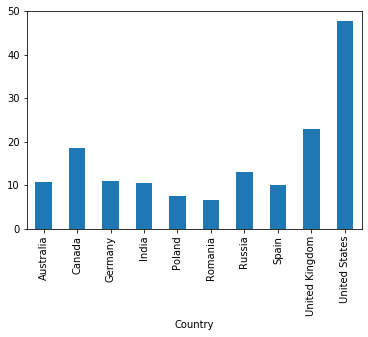

In [212]:
MinAndMaxCostOfLivingMultipleValues['diff','Cost of Living Index'].plot(kind = 'bar')

Lo and behold but the United States seems to be the most unequal of the 10 countries included! Granted, the US has almost 40 more cities included in the report than any other country so there is almost a guarantee that smaller US cities are being included. Just for curiousity we can back into which city is the highest and lowest for each country using the values we got in the pivot table above.




In [269]:
MinByCountry = MinAndMaxCostOfLivingMultipleValues['amin','Cost of Living Index']
MinByCountry.values
#MinByCoutryDict = dict(zip(MinByCountry.index,MinByCountry.values))

backingIntoData = pd.DataFrame()
for country,value in list(zip(MinByCountry.index,MinByCountry.values)):
  backingIntoData = backingIntoData.append(cleanData3.loc[(cleanData3['Year']==2020) & (cleanData3['Country'] == country) & (cleanData3['Cost of Living Index']== value)])
backingIntoData


,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
134,,"Adelaide, Australia",68.40,27.79,48.98,65.29,63.18,116.12,2020,False,"[Adelaide, Australia]",2,Adelaide,Australia,
197,,"London, Canada",59.95,26.64,44.02,51.33,60.18,97.85,2020,False,"[London, Canada]",2,London,Canada,
195,,"Aachen, Germany",61.24,20.38,41.70,49.03,48.14,123.94,2020,False,"[Aachen, Germany]",2,Aachen,Germany,
439,,"Thiruvananthapuram, India",19.77,4.33,12.38,20.31,10.66,62.74,2020,False,"[Thiruvananthapuram, India]",2,Thiruvananthapuram,India,
337,,"Lublin, Poland",36.54,12.39,24.99,27.87,28.42,65.02,2020,False,"[Lublin, Poland]",2,Lublin,Poland,
381,,"Craiova, Romania",32.75,7.72,20.78,27.83,25.58,48.64,2020,False,"[Craiova, Romania]",2,Craiova,Romania,
365,,"Izhevsk, Russia",34.68,7.07,21.47,29.29,31.28,37.20,2020,False,"[Izhevsk, Russia]",2,Izhevsk,Russia,
241,,"Santa Cruz de Tenerife, Spain",49.20,18.59,34.56,40.40,50.65,67.83,2020,False,"[Santa Cruz de Tenerife, Spain]",2,Santa Cruz de Tenerife,Spain,
202,,"Kingston upon Hull, United Kingdom",58.51,18.44,39.35,42.96,64.59,90.28,2020,False,"[Kingston upon Hull, United Kingdom]",2,Kingston upon Hull,United Kingdom,
220,,"El Paso, TX, United States",52.38,22.71,38.19,52.57,39.93,127.67,2020,True,"[El Paso, TX, United States]",3,El Paso,United States,TX


These are the cheapest cities per country. 

In [270]:
MaxByCountry = MinAndMaxCostOfLivingMultipleValues['amax','Cost of Living Index']
MaxByCountry.values
#MinByCoutryDict = dict(zip(MinByCountry.index,MinByCountry.values))

backingIntoData2 = pd.DataFrame()
for country,value in list(zip(MaxByCountry.index,MaxByCountry.values)):
  backingIntoData2 = backingIntoData2.append(cleanData3.loc[(cleanData3['Year']==2020) & (cleanData3['Country'] == country) & (cleanData3['Cost of Living Index']== value)])
backingIntoData2

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
36,,"Sydney, Australia",79.08,53.16,66.68,71.21,69.36,97.02,2020,False,"[Sydney, Australia]",2,Sydney,Australia,
41,,"Toronto, Canada",78.49,50.51,65.10,73.92,76.31,77.60,2020,False,"[Toronto, Canada]",2,Toronto,Canada,
95,,"Munich, Germany",72.19,43.96,58.69,54.04,74.69,95.97,2020,False,"[Munich, Germany]",2,Munich,Germany,
395,,"Gurgaon, India",30.28,9.56,20.37,28.26,23.68,91.58,2020,False,"[Gurgaon, India]",2,Gurgaon,India,
269,,"Warsaw, Poland",44.09,21.74,33.40,34.51,38.90,63.00,2020,False,"[Warsaw, Poland]",2,Warsaw,Poland,
303,,"Bucharest, Romania",39.23,13.16,26.76,31.78,37.60,52.76,2020,False,"[Bucharest, Romania]",2,Bucharest,Romania,
250,,"Moscow, Russia",47.65,31.39,39.88,35.67,48.82,52.28,2020,False,"[Moscow, Russia]",2,Moscow,Russia,
199,,"Palma de Mallorca, Spain",59.31,27.83,44.25,46.07,62.80,57.73,2020,False,"[Palma de Mallorca, Spain]",2,Palma de Mallorca,Spain,
27,,"London, United Kingdom",81.30,70.01,75.90,57.31,89.04,78.16,2020,False,"[London, United Kingdom]",2,London,United Kingdom,
10,,"New York, NY, United States",100.00,100.00,100.00,100.00,100.00,100.00,2020,True,"[New York, NY, United States]",3,New York,United States,NY


And these are the most expensive. No surprises except for Gurgaon, never heard of that! 

From Wiki 


> Gurgaon has become a leading financial centre in India after Mumbai and Chennai.[5] The city's economic growth story started when the leading Indian automobile manufacturer Maruti Suzuki India Limited established a manufacturing plant in Gurgaon in the 1970s.[6] Today, Gurgaon has local offices for more than 250 Fortune 500 companies...In March 2019, Gurgaon was named the most polluted city in the world, according to data released by IQ Air Visual and Greenpeace.



Back to our analyses, we have another thing to keep track of. How these indices are changing over time! I am particularly interested in US cities in seeing how different cities have grown over the past 10 years. 


In [273]:
statesByYear = cleanData3.loc[cleanData3['Country']=='United States'].pivot(index='CityName', columns = 'Year', values = ['Cost of Living Index','Rent Index'])


ValueError: ignored

I am getting a duplicate record error, let's check to see what's going on there

In [274]:
duplicates = cleanData3.loc[(cleanData3.duplicated(subset=['CityName','Year'], keep=False))&(cleanData3['Country'] == 'United States')] 
#USduplicates = cleanData3.loc[(cleanData3['Country'] == 'United States')  & duplicates]
duplicates

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
87,,"San Jose, CA, United States",81.88,65.10,75.86,84.01,59.31,125.59,2011,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
79,,"San Jose, CA, United States",94.11,73.36,86.64,82.33,82.04,113.13,2012,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
134,,"San Jose, CA, United States",87.42,79.13,83.44,82.46,84.44,126.65,2013,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
149,,"Saint Petersburg, FL, United States",88.71,37.78,63.97,100.46,64.70,84.56,2014,True,"[Saint Petersburg, FL, United States]",3,Saint Petersburg,United States,FL
159,,"San Jose, CA, United States",87.39,72.12,79.97,96.06,76.20,129.95,2014,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
246,,"Birmingham, AL, United States",71.18,36.42,54.29,75.74,64.13,170.38,2014,True,"[Birmingham, AL, United States]",3,Birmingham,United States,AL
109,,"San Jose, CA, United States",85.87,77.57,81.82,96.48,72.08,143.23,2015,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
103,,"Naples, FL, United States",77.50,33.52,56.37,81.77,69.58,139.76,2016,True,"[Naples, FL, United States]",3,Naples,United States,FL
106,,"San Jose, CA, United States",77.11,80.71,78.84,81.00,70.26,169.92,2016,True,"[San Jose, CA, United States]",3,San Jose,United States,CA
158,,"Vancouver, WA, United States",72.67,31.10,52.69,76.76,58.86,152.22,2016,True,"[Vancouver, WA, United States]",3,Vancouver,United States,WA


My duplicate values were being caused by cities with the same City Name (i.e. London, Ontario).. Since both Portland Maine and Portland Oregon are in the data set, I should use a column created by the City and State instead!!


In [271]:
cleanData3US = cleanData3.loc[cleanData3['Country']=='United States'].copy()
cleanData3US['City,State'] = cleanData3US['CityName'] + ', ' + cleanData3US['US State']
statesByYear = cleanData3US.pivot(index='City,State', columns = 'Year', values = ['Cost of Living Index','Rent Index'])
statesByYear

Cost of Living Index                ... Rent Index              
Year                                2010   2011   2012  ...       2018   2019   2020
City,State                                              ...                         
Akron, OH                            NaN    NaN    NaN  ...      21.57    NaN    NaN
Albany, NY                           NaN    NaN    NaN  ...      30.82  31.09  33.00
Albuquerque, NM                      NaN  70.35    NaN  ...      25.50  27.13    NaN
Allentown, PA                        NaN    NaN    NaN  ...        NaN    NaN    NaN
Anaheim, CA                          NaN    NaN    NaN  ...        NaN    NaN    NaN
...                                  ...    ...    ...  ...        ...    ...    ...
Virginia Beach, VA                   NaN    NaN    NaN  ...      37.42    NaN    NaN
Washington, DC                       NaN    NaN  98.19  ...      73.30  70.51  78.18
West Palm Beach, FL                  NaN    NaN    NaN  ...      43.11    NaN    NaN
Wichita, KS                          NaN    NaN    NaN  ...      24.63    NaN    NaN
Winston-Salem, NC                    NaN    NaN    NaN  ...      24.96    NaN    NaN

[147 rows x 22 columns]


However, another thing to consider is that there are different cities included into report each year. Some years have more than 400 too so that's a lot of data! 

I think that will create issues in getting the mean per country/state as different years will be pulling from different cities. Let's clean it up again so that we are only getting the cities that are in every data set. We can check by only selecting the cities that have 11 values (2010-2020)



In [121]:
#There was an error running this where I had added some additional rows by accident 
#cleanData3.loc[cleanData3['CityName']=='Zagreb'].groupby(by=['City','Year']).count()
cityGroupCount = cleanData3.groupby(by=['City']).count()
cityGroupCount

,Rank,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
City,,,,,,,,,,,,,,
"'afrin, Syria",1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Aachen, Germany",8,8,8,8,8,8,8,8,8,8,8,8,8,8
"Aalborg, Denmark",7,7,7,7,7,7,7,7,7,7,7,7,7,7
"Abbotsford, Canada",2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Aberdeen, United Kingdom",9,9,9,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zagreb, Croatia",11,11,11,11,11,11,11,11,11,11,11,11,11,11
"Zaporizhzhya, Ukraine",1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Zaragoza (Saragossa), Spain",5,5,5,5,5,5,5,5,5,5,5,5,5,5


Now that we have seen that some cities are in the data set 11 times, let's try selecting only them to see how many we have 



In [122]:
goodCities = cityGroupCount.loc[cityGroupCount['Rank']==11]
len(goodCities)

83

There are 83 cities that have data for all 11 years, let's use these as our main data set! 

In [123]:
goodCitiesList = list(goodCities.index)
print(goodCitiesList)
print(len(goodCitiesList))



['Abu Dhabi, United Arab Emirates', 'Ahmedabad, India', 'Amman, Jordan', 'Amsterdam, Netherlands', 'Athens, Greece', 'Austin, TX, United States', 'Bangalore, India', 'Bangkok, Thailand', 'Banja Luka, Bosnia And Herzegovina', 'Barcelona, Spain', 'Beijing, China', 'Belgrade, Serbia', 'Berlin, Germany', 'Bogota, Colombia', 'Boston, MA, United States', 'Brussels, Belgium', 'Bucharest, Romania', 'Budapest, Hungary', 'Buenos Aires, Argentina', 'Chennai, India', 'Cluj-Napoca, Romania', 'Copenhagen, Denmark', 'Delhi, India', 'Dubai, United Arab Emirates', 'Dublin, Ireland', 'Edmonton, Canada', 'Frankfurt, Germany', 'Geneva, Switzerland', 'Guadalajara, Mexico', 'Helsinki, Finland', 'Hong Kong, Hong Kong', 'Hyderabad, India', 'Istanbul, Turkey', 'Jakarta, Indonesia', 'Johannesburg, South Africa', 'Kiev (Kyiv), Ukraine', 'Kolkata, India', 'Kuala Lumpur, Malaysia', 'Leeds, United Kingdom', 'Lisbon, Portugal', 'Ljubljana, Slovenia', 'London, United Kingdom', 'Lyon, France', 'Madrid, Spain', 'Medell

We can save the index of our filtered df as a list to filter the original data set on (using the pandas series function "isin()"

In [124]:
cleanData4 = cleanData3.loc[cleanData3['City'].isin(goodCitiesList)]
cleanData4

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Year,USorOther,CitySplit,CityCheck,CityName,Country,US State
0,,"Stavanger, Norway",169.20,103.02,139.63,190.35,220.64,50.21,2010,False,"[Stavanger, Norway]",2,Stavanger,Norway,
1,,"Oslo, Norway",152.85,71.02,116.28,133.02,142.31,77.84,2010,False,"[Oslo, Norway]",2,Oslo,Norway,
3,,"Copenhagen, Denmark",138.91,78.63,111.97,116.60,159.09,91.30,2010,False,"[Copenhagen, Denmark]",2,Copenhagen,Denmark,
4,,"Zurich, Switzerland",132.03,99.23,117.37,102.52,157.47,111.08,2010,False,"[Zurich, Switzerland]",2,Zurich,Switzerland,
5,,"Paris, France",130.30,80.51,108.05,115.25,123.95,64.19,2010,False,"[Paris, France]",2,Paris,France,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,,"Bangalore, India",27.22,8.89,18.45,27.20,20.76,68.14,2020,False,"[Bangalore, India]",2,Bangalore,India,
415,,"Ahmedabad, India",25.58,7.22,16.79,25.90,17.72,38.52,2020,False,"[Ahmedabad, India]",2,Ahmedabad,India,
417,,"Chennai, India",25.32,6.59,16.36,25.95,15.87,53.06,2020,False,"[Chennai, India]",2,Chennai,India,
418,,"Hyderabad, India",25.32,6.41,16.27,26.25,16.68,57.90,2020,False,"[Hyderabad, India]",2,Hyderabad,India,


The resulting data set is 913 rows which happens to be 11 * 83 (the amount of cities). That seems right! Let's start analysing this cleaned up data set. 

We can whittle this down to the US.

In [128]:
cleanData4US = cleanData4.loc[cleanData4['Country']=='United States'].copy()
cleanData4US['City,State'] = cleanData4US['CityName'] + ', ' + cleanData4US['US State']
statesByYear = cleanData4US.pivot(index='City,State', columns = 'Year', values = ['Cost of Living Index','Rent Index'])
statesByYear

Cost of Living Index                  ... Rent Index                
Year                              2010    2011    2012  ...       2018    2019    2020
City,State                                              ...                           
Austin, TX                       91.38   73.44   78.92  ...      49.80   49.83   52.04
Boston, MA                       89.11   89.83  106.80  ...      78.72   72.59   74.47
Minneapolis, MN                  92.85   83.47   90.26  ...      45.65   46.24   45.26
New York, NY                    100.00  100.00  100.00  ...     100.00  100.00  100.00
Philadelphia, PA                 85.45   78.55   88.36  ...      48.09   45.39   46.87
San Francisco, CA                90.64   88.08  102.52  ...     115.36  106.05  115.58
Seattle, WA                     100.33   93.73  101.04  ...      64.41   63.68   65.70
Tampa, FL                       109.64   89.07   89.97  ...      42.09   38.84   40.83

[8 rows x 22 columns]

This is an interesting pivot table! The Rent Index shows that Seattle and San Francisco really jump up against New York in the mid 2010's. It's also interesting to see that the Cost of Living in Seattle otherwise is going down, I wonder if this is because of cheaper distribution costs...

Let's visualize these points using matplotlib to see the change in the Rent Index over the 11 years.

Text(0, 0.5, 'Rent Index')

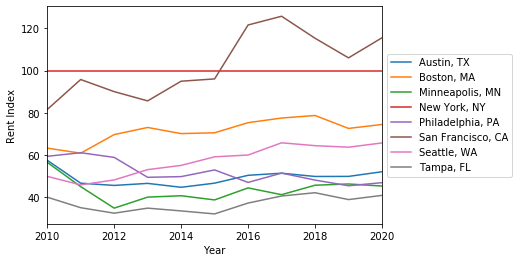

In [129]:
import matplotlib.pyplot as plt


#cleanData4US[['City,State','Year','Rent Index']].plot(x='Year', y = 'City,State')
statesByYear = cleanData4US.pivot(index='Year', columns = 'City,State', values = 'Rent Index').plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Rent Index')




And there you have it! While Austin, Minneapolis, Tampa stay flat and Philadelphia decreases, Boston, Seattle and SF are increasing w.r.t New York's rent cost. We can probably summarize this another way by plotting the 2020 value directly against the 2010 value.

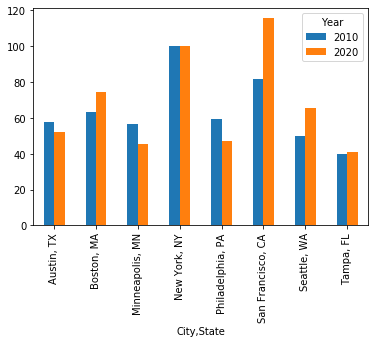

In [130]:
 states2010vs2020 = cleanData4US.loc[cleanData4US['Year'].isin([2010,2020])].pivot(index='City,State', columns = 'Year', values = 'Rent Index')
 states2010vs2020.plot(kind='bar')

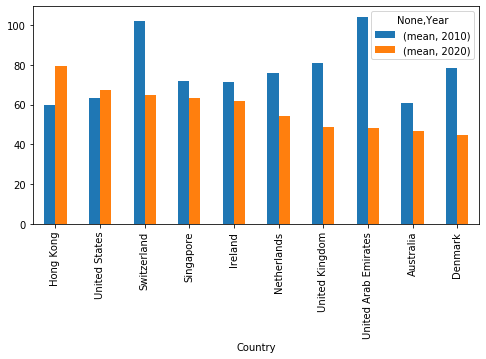

In [298]:
allcities2010vs2020 = cleanData4.loc[cleanData4['Year'].isin([2010,2020])].pivot_table(index='Country', columns = 'Year', values = 'Rent Index', aggfunc = [np.mean])
top10 = allcities2010vs2020.sort_values(by = ('mean',2020), ascending = False).head(10)
#fig, ax = plt.subplots()
top10.plot(kind = 'bar', figsize=(8, 4))
#plt.scale(2)
#ax.barh('Country', ['mean'])

I think it is interesting to see that most countries in the top 10 seem to be not being seem the same amount of increases in rent as we are in NYC over the last 10 years! 

In [303]:
cleanData4.loc[(cleanData4['Year'].isin([2010,2020]))&(cleanData4['Country']=='Switzerland')][['City','Year','Rent Index']]


,City,Year,Rent Index
4,"Zurich, Switzerland",2010,99.23
6,"Geneva, Switzerland",2010,104.85
0,"Zurich, Switzerland",2020,61.66
3,"Geneva, Switzerland",2020,68.47


In [314]:
rentrankers2010 = cleanData3.loc[cleanData3['Year'] == 2010][['Year','City','Rent Index']].sort_values(by = 'Rent Index', ascending = False ).head(20)
rentrankers2020 = cleanData3.loc[cleanData3['Year'] == 2020][['Year','City','Rent Index']].sort_values(by = 'Rent Index', ascending = False ).head(20)
rentRankers2010and2020 = rentrankers2010.append(rentrankers2020[['Year','City','Rent Index']])
rentRankers2010and2020.head(40)

,Year,City,Rent Index
49,2010,"Abu Dhabi, United Arab Emirates",118.06
10,2010,"London, United Kingdom",110.61
6,2010,"Geneva, Switzerland",104.85
0,2010,"Stavanger, Norway",103.02
29,2010,"New York, NY, United States",100.00
4,2010,"Zurich, Switzerland",99.23
61,2010,"Tehran, Iran",90.51
56,2010,"Dubai, United Arab Emirates",90.21
7,2010,"Milan, Italy",82.38
21,2010,"Sydney, Australia",81.65


While in 2010, only a few American cities made the top 20 for rent index, now almost 3/4th's of the list is made up of the US! Also, NYC moved up to be the 2nd most expensive city after being the 5th. SF went from the 11th spot to the 1st!